In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer,SimpleImputer,IterativeImputer
from sklearn.preprocessing import LabelEncoder,normalize,LabelBinarizer,OneHotEncoder
from sklearn.metrics import confusion_matrix,classification_report, roc_auc_score,accuracy_score
from sklearn.model_selection import train_test_split ,GridSearchCV ,cross_val_predict,cross_val_score
from sklearn.ensemble import RandomForestClassifier,StackingClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier

In [3]:
df=pd.read_csv("https://raw.githubusercontent.com/ammy20019/hackathons/master/MLH%20Hacklytics%202021/financial_data.csv")
df.head()

,entry_id,age,pay_schedule,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,has_debt,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed
0,7629673,40,bi-weekly,1,3135,0,3,3,6,2,1,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,1
1,3560428,61,weekly,0,3180,0,6,3,2,7,1,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,0
2,6934997,23,weekly,0,1540,6,0,0,7,1,1,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,0
3,5682812,40,bi-weekly,0,5230,0,6,1,2,7,1,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,1
4,5335819,33,semi-monthly,0,3590,0,5,2,2,8,1,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,0


In [4]:
df=df.drop(columns = ['entry_id',])
df.head()

,age,pay_schedule,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,has_debt,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed
0,40,bi-weekly,1,3135,0,3,3,6,2,1,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,1
1,61,weekly,0,3180,0,6,3,2,7,1,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,0
2,23,weekly,0,1540,6,0,0,7,1,1,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,0
3,40,bi-weekly,0,5230,0,6,1,2,7,1,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,1
4,33,semi-monthly,0,3590,0,5,2,2,8,1,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,0


In [5]:
le = LabelEncoder()
df["pay_schedule"] =le.fit_transform(df["pay_schedule"])

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
topfeatures = SelectKBest(score_func = chi2, k = 7)
x=df.drop("e_signed",axis=1)
y = df["e_signed"]
fit = topfeatures.fit(x, y)
xyscore = pd.DataFrame(fit.scores_)
xycolumn = pd.DataFrame(x.columns)

In [7]:
featurescore = pd.concat([xycolumn, xyscore], axis = 1)
featurescore.columns = ["Feature", "Score"]
featurescore = featurescore.sort_values(by = "Score", ascending= False)
featurescore

,Feature,Score
11,risk_score,514968.975244
10,amount_requested,44498.468276
3,income,10916.799899
0,age,552.148409
7,personal_account_m,169.219903
18,inquiries_last_month,23.693774
2,home_owner,23.136657
6,current_address_year,13.612249
8,personal_account_y,11.409892
1,pay_schedule,9.460445


In [8]:
df=df.drop(["risk_score_4","risk_score_5","risk_score_2","risk_score_3","ext_quality_score_2","years_employed","ext_quality_score"],axis=1)

In [9]:
df.describe()

,age,pay_schedule,home_owner,income,months_employed,current_address_year,personal_account_m,personal_account_y,has_debt,amount_requested,risk_score,inquiries_last_month,e_signed
count,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000
mean,43.015412,0.926290,0.425173,3657.214653,1.186006,3.584711,3.427183,3.503350,0.795399,950.446449,61086.302211,6.457226,0.538251
std,11.873107,1.237135,0.494383,1504.890063,2.400897,2.751937,2.216440,1.955568,0.403421,698.543683,15394.255020,3.673093,0.498549
min,18.000000,0.000000,0.000000,905.000000,0.000000,0.000000,0.000000,0.000000,0.000000,350.000000,2100.000000,1.000000,0.000000
25%,34.000000,0.000000,0.000000,2580.000000,0.000000,2.000000,2.000000,2.000000,1.000000,600.000000,49350.000000,4.000000,0.000000
50%,42.000000,0.000000,0.000000,3260.000000,0.000000,3.000000,2.000000,3.000000,1.000000,700.000000,61200.000000,6.000000,1.000000
75%,51.000000,2.000000,1.000000,4670.000000,1.000000,5.000000,5.000000,4.000000,1.000000,1100.000000,72750.000000,8.000000,1.000000
max,96.000000,3.000000,1.000000,9985.000000,11.000000,12.000000,11.000000,15.000000,1.000000,10200.000000,99750.000000,30.000000,1.000000


In [10]:
def print_score(clf, X_train, X_test, y_train, y_test,c,i):
    '''
    v0.1 Follow the scikit learn library format in terms of input
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    #labels = ['True Neg','False Pos','False Neg','True Pos']
    #labels = np.asarray(labels).reshape(2,2)
    lb = LabelBinarizer()
    lb.fit(y_train)
    print("\ntraining performance\n")
    '''
    training performance
    '''
    res = clf.predict(X_train)
    print("Train Result:\n")
    print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train,res)))
    print("Classification Report: \n {}\n".format(classification_report(y_train,res)))
    print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train,res)))
    plt.figure(i)
    plt.title("{} training".format(c), fontsize =20)
    sns.heatmap(confusion_matrix(y_train,res), annot=True,cmap="YlGnBu")
    print("ROC AUC: {0:.4f}\n".format(roc_auc_score(lb.transform(y_train), lb.transform(res))))
        
    print("\ntest performance\n")
    '''
    test performance
    '''
    res_test = clf.predict(X_test)
    print("Test Result:\n")        
    print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test,res_test)))
    print("Classification Report: \n {}\n".format(classification_report(y_test,res_test)))
    print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test,res_test))) 
    plt.figure(i+1)
    plt.title("{} test".format(c), fontsize =20)
    sns.heatmap(confusion_matrix(y_test, res_test), annot=True,cmap="YlGnBu")
    print("ROC AUC: {0:.4f}\n".format(roc_auc_score(lb.transform(y_test),lb.transform(res_test))))

In [11]:
clf={}
clf["svc"]=SVC(kernel='poly')
clf["DT"]=DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=5, min_samples_leaf=5) 
clf["knn"]=KNeighborsClassifier(n_neighbors=5,p=2, metric='minkowski')
clf["RF"]=RandomForestClassifier(n_estimators=200,random_state=100,max_depth=5,max_features='auto')
clf["AD"]=AdaBoostClassifier(n_estimators=200,random_state = 100)
clf["GB"]=GradientBoostingClassifier(n_estimators=200,random_state = 100,max_features="auto")
clf["xgb"]=xgb.XGBClassifier(learning_rate=0.1,n_estimators=200,objective='binary:logistic',nthread= 4,n_jobs= 4,base_score= 0.6)
clf["AD_RF"]=AdaBoostClassifier(base_estimator=clf["RF"],n_estimators=200,random_state = 100)
clf["BAGG"]=BaggingClassifier(base_estimator=clf["DT"], n_estimators=1000, bootstrap=True, oob_score=True,n_jobs=-1, random_state=100)
clf["St"]=StackingClassifier(estimators=[('DT',clf["DT"] ),('RFC', clf["RF"])],final_estimator=LogisticRegression())

In [13]:
def apply_models(data,c):
  x=data.drop("e_signed",axis=1)
  y=data["e_signed"]
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)
  print(x_train.shape)
  print(x_test.shape)
  print(y_train.shape)
  print(y_test.shape)
  j=0
  for i in c:
    print("c:",i)
    clf[i].fit(x_train,y_train)
    print_score(clf[i], x_train, x_test, y_train, y_test,i,j)
    j+=2

(14326, 12)
(3582, 12)
(14326,)
(3582,)
c: svc

training performance

Train Result:

accuracy score: 0.5385

Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      6612
           1       0.54      1.00      0.70      7714

    accuracy                           0.54     14326
   macro avg       0.27      0.50      0.35     14326
weighted avg       0.29      0.54      0.38     14326


Confusion Matrix: 
 [[   0 6612]
 [   0 7714]]

ROC AUC: 0.5000


test performance



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Result:

accuracy score: 0.5374

Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1657
           1       0.54      1.00      0.70      1925

    accuracy                           0.54      3582
   macro avg       0.27      0.50      0.35      3582
weighted avg       0.29      0.54      0.38      3582


Confusion Matrix: 
 [[   0 1657]
 [   0 1925]]

ROC AUC: 0.5000

c: DT

training performance

Train Result:

accuracy score: 0.6132

Classification Report: 
               precision    recall  f1-score   support

           0       0.63      0.38      0.48      6612
           1       0.61      0.81      0.69      7714

    accuracy                           0.61     14326
   macro avg       0.62      0.60      0.59     14326
weighted avg       0.62      0.61      0.59     14326




/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix: 
 [[2525 4087]
 [1454 6260]]

ROC AUC: 0.5967


test performance

Test Result:

accuracy score: 0.5930

Classification Report: 
               precision    recall  f1-score   support

           0       0.60      0.36      0.45      1657
           1       0.59      0.80      0.68      1925

    accuracy                           0.59      3582
   macro avg       0.60      0.58      0.56      3582
weighted avg       0.60      0.59      0.57      3582


Confusion Matrix: 
 [[ 589 1068]
 [ 390 1535]]

ROC AUC: 0.5764

c: knn

training performance

Train Result:

accuracy score: 0.7218

Classification Report: 
               precision    recall  f1-score   support

           0       0.71      0.66      0.69      6612
           1       0.73      0.77      0.75      7714

    accuracy                           0.72     14326
   macro avg       0.72      0.72      0.72     14326
weighted avg       0.72      0.72      0.72     14326


Confusion Matrix: 
 [[4372 2240]
 [174

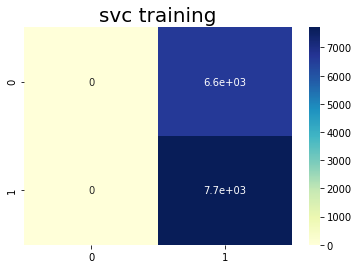

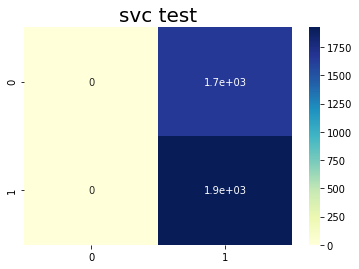

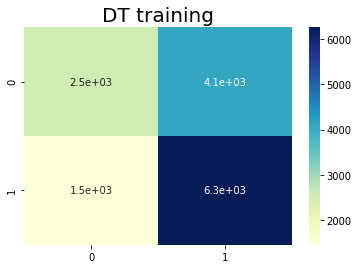

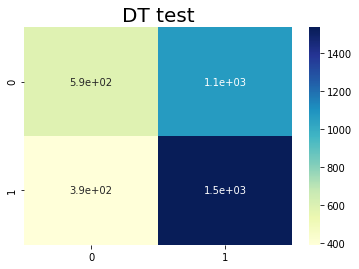

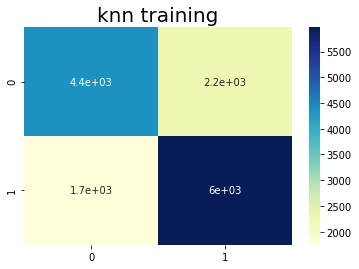

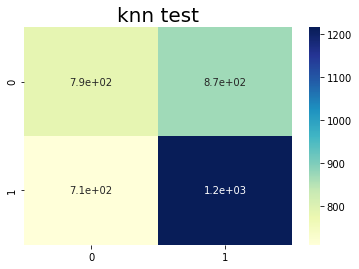

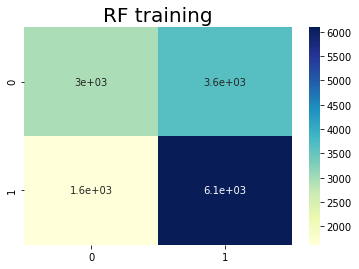

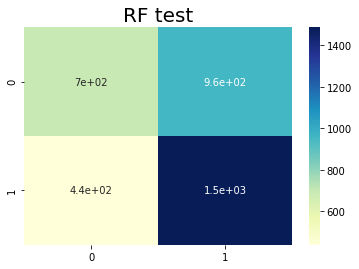

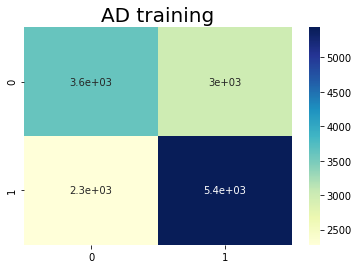

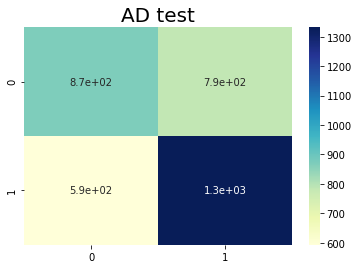

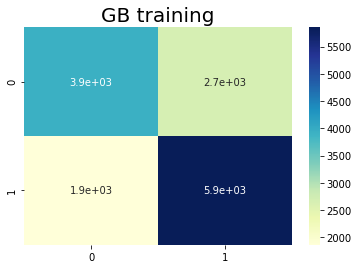

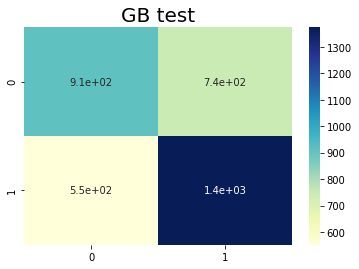

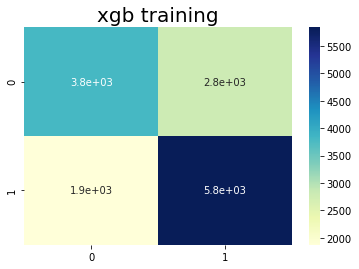

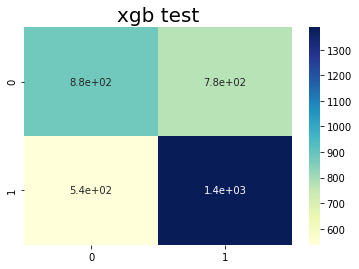

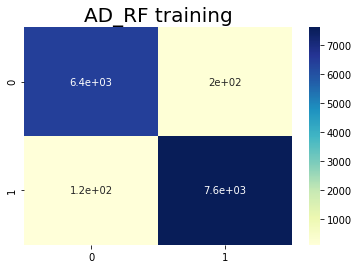

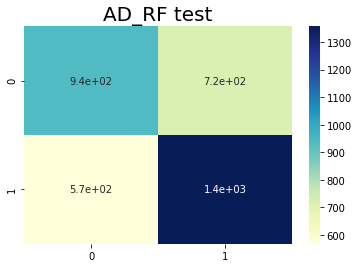

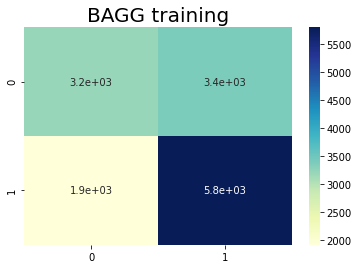

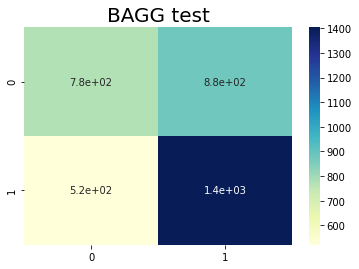

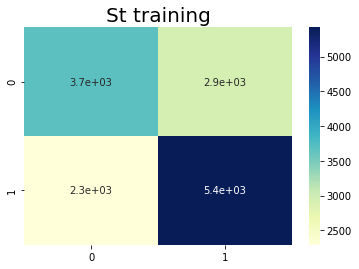

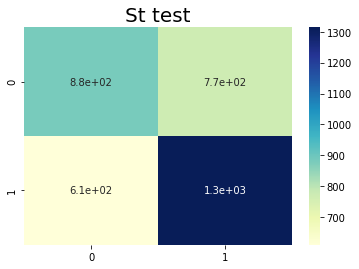

In [14]:
apply_models(df,clf)